This code is for:

J. P. Cohen, H. Z. Lo, and Y. Bengio, “Count-ception: Counting by Fully Convolutional Redundant Counting,” 2017.
https://arxiv.org/abs/1703.08710


Here is a video of the learning in progress:
[![](http://img.youtube.com/vi/ej5bj0mlQq8/0.jpg)](https://www.youtube.com/watch?v=ej5bj0mlQq8)

The cell dataset used in this work is available from [VGG](http://www.robots.ox.ac.uk/~vgg/research/counting/cells.zip) and [Academic Torrents](http://academictorrents.com/details/b32305598175bb8e03c5f350e962d772a910641c)


In [1]:
import sys,os,time,random
import numpy as np
import matplotlib
matplotlib.use('Agg');
import matplotlib.pyplot as plt
plt.set_cmap('jet');

import theano
import theano.tensor as T 
import lasagne

import skimage
from skimage.io import imread, imsave
import pickle
import scipy

from os import walk
print "theano",theano.version.full_version
print "lasagne",lasagne.__version__

theano 0.10.0dev1.dev-743f7aa9c477e2c7fcee17cbc5e3c03fb455e5a6
lasagne 0.2.dev1


Using cuDNN version 5105 on context None
Mapped name None to device cuda0: Tesla P100-SXM2-16GB (0000:89:00.0)


In [2]:
%matplotlib inline

In [3]:
import sys
import argparse

if len(sys.argv) == 3 and sys.argv[1] == "-f": #on jupyter
    sys.argv = ['']
    
parser = argparse.ArgumentParser(description='Count-ception')

parser.add_argument('-seed', type=int, nargs='?',default=0, help='random seed for split and init')
parser.add_argument('-nsamples', type=int, nargs='?',default=32, help='Number of samples (N) in train and valid')
parser.add_argument('-stride', type=int, nargs='?',default=1, help='The args.stride at the initial layer')
parser.add_argument('-lr', type=float, nargs='?',default=0.00005, help='This will set the learning rate ')
parser.add_argument('-kern', type=str, nargs='?',default="sq", help='This can be gaus or sq')
parser.add_argument('-cov', type=float, nargs='?',default=1, help='This is the covariance when kern=gaus')
parser.add_argument('-scale', type=int, nargs='?',default=1, help='Scale the input image and labels')
parser.add_argument('-data', type=str, nargs='?',default="cells", help='Dataset folder')
parser.add_argument('-framesize', type=int, nargs='?',default=256, help='Size of the images processed at once')


args = parser.parse_args()

In [4]:
print args

Namespace(cov=1, data='cells', framesize=256, kern='sq', lr=5e-05, nsamples=32, scale=1, seed=0, stride=1)


In [5]:
job_id = os.environ.get('SLURM_JOB_ID')

if job_id == None:
    job_id = os.environ.get('PBS_JOBID')

print "job_id",job_id

job_id 18080


In [6]:
patch_size = 32
framesize = int(args.framesize/args.scale)
framesize_h = framesize_w = framesize
noutputs = 1
channels = 3

In [7]:
paramfilename = str(args.scale) + "-" + str(patch_size) + "-" + args.data + "-" + args.kern + str(args.cov) + "_params.p"
datasetfilename = str(args.scale) + "-" + str(patch_size) + "-" + str(framesize) + "-" + args.kern + str(args.stride) + "-" + args.data + "-" + str(args.cov) + "-dataset.p"
print paramfilename
print datasetfilename

1-32-cells-sq1_params.p
1-32-256-sq1-cells-1-dataset.p


In [8]:
random.seed(args.seed)
np.random.seed(args.seed)
lasagne.random.set_rng(np.random.RandomState(args.seed))

In [9]:
from lasagne.layers.normalization import BatchNormLayer
from lasagne.layers import InputLayer, ConcatLayer, Conv2DLayer

input_var = T.tensor4('inputs')
input_var_ex = T.ivector('input_var_ex')

def ConvFactory(data, num_filter, filter_size, stride=1, pad=0, nonlinearity=lasagne.nonlinearities.leaky_rectify):
    data = lasagne.layers.batch_norm(Conv2DLayer(
        data, num_filters=num_filter,
        filter_size=filter_size,
        stride=stride, pad=pad,
        nonlinearity=nonlinearity,
        W=lasagne.init.GlorotUniform(gain='relu')))
    return data

def SimpleFactory(data, ch_1x1, ch_3x3):
    conv1x1 = ConvFactory(data=data, filter_size=1, pad=0, num_filter=ch_1x1)
    conv3x3 = ConvFactory(data=data, filter_size=3, pad=1, num_filter=ch_3x3) 
    concat = ConcatLayer([conv1x1, conv3x3])
    return concat


input_shape = (None, channels, framesize, framesize)
img = InputLayer(shape=input_shape, input_var=input_var[input_var_ex])
net = img


net = ConvFactory(net, filter_size=3, num_filter=64, pad=patch_size)
print net.output_shape
net = SimpleFactory(net, 16, 16)
print net.output_shape
net = SimpleFactory(net, 16, 32)
print net.output_shape
net = ConvFactory(net, filter_size=14, num_filter=16) 
print net.output_shape
net = SimpleFactory(net, 112, 48)
print net.output_shape
net = SimpleFactory(net, 64, 32)
print net.output_shape
net = SimpleFactory(net, 40, 40)
print net.output_shape
net = SimpleFactory(net, 32, 96)
print net.output_shape
net = ConvFactory(net, filter_size=18, num_filter=32) 
print net.output_shape
net = ConvFactory(net, filter_size=1, pad=0, num_filter=64)
print net.output_shape
net = ConvFactory(net, filter_size=1, pad=0, num_filter=64)
print net.output_shape
net = ConvFactory(net, filter_size=1, num_filter=1, stride=args.stride)
print net.output_shape


(None, 64, 318, 318)
(None, 32, 318, 318)
(None, 48, 318, 318)
(None, 16, 305, 305)
(None, 160, 305, 305)
(None, 96, 305, 305)
(None, 80, 305, 305)
(None, 128, 305, 305)
(None, 32, 288, 288)
(None, 64, 288, 288)
(None, 64, 288, 288)
(None, 1, 288, 288)


In [10]:
output_shape = lasagne.layers.get_output_shape(net)
real_input_shape = (None, input_shape[1], input_shape[2]+2*patch_size, input_shape[3]+2*patch_size)
print "real_input_shape:",real_input_shape,"-> output_shape:",output_shape

real_input_shape: (None, 3, 320, 320) -> output_shape: (None, 1, 288, 288)


In [11]:
print "network output size should be",(input_shape[2]+2*patch_size)-(patch_size)

network output size should be 288


In [12]:
if (args.kern == "sq"):
    ef = ((patch_size/args.stride)**2.0)
elif (args.kern == "gaus"):
    ef = 1.0
print "ef", ef

prediction = lasagne.layers.get_output(net, deterministic=True)
prediction_count = (prediction/ef).sum(axis=(2,3))

classify = theano.function([input_var, input_var_ex], prediction)

ef 1024.0


In [13]:
train_start_time = time.time()
print classify(np.zeros((1,channels,framesize,framesize), dtype=theano.config.floatX), [0]).shape
print time.time() - train_start_time, "sec"

train_start_time = time.time()
print classify(np.zeros((1,channels,framesize,framesize), dtype=theano.config.floatX), [0]).shape
print time.time() - train_start_time, "sec"


(1, 1, 288, 288)
0.50723695755 sec
(1, 1, 288, 288)
0.053197145462 sec


In [1]:
def genGausImage(framesize, mx, my, cov=1):
    x, y = np.mgrid[0:framesize, 0:framesize]
    pos = np.dstack((x, y))
    mean = [mx, my]
    cov = [[cov, 0], [0, cov]]
    rv = scipy.stats.multivariate_normal(mean, cov).pdf(pos)
    return rv/rv.sum()

def getDensity(width, markers):
    gaus_img = np.zeros((width,width))
    for k in range(width):
        for l in range(width):
            if (markers[k,l] > 0.5):
                gaus_img += genGausImage(len(markers),k-patch_size/2,l-patch_size/2,cov)
    return gaus_img

def getMarkersCells(labelPath, scale, size):  
    labs = imread(labelPath)
    if len(labs.shape) == 2:
        lab = labs[:,:]/255
    elif len(labs.shape) == 3:
        lab = labs[:,:,0]/255
    else:
        print "unknown label format"
    
    binsize = [scale,scale]
    out = np.zeros(size)
    for i in xrange(binsize[0]):
        for j in xrange(binsize[1]):
            out = np.maximum(lab[i::binsize[0], j::binsize[1]], out)
        
    print lab.sum(),out.sum()
    assert np.allclose(lab.sum(),out.sum(), 1)
    
    return out

def getCellCountCells(markers,(x,y,h,w)):
    types = [0] * noutputs
    for i in range(noutputs):
        types[i] = (markers[y:y+h,x:x+w] == 1).sum()
        #types[i] = (markers[y:y+h,x:x+w] != -1).sum()
    return types

def getLabelsCells(markers, img_pad, base_x, base_y, stride, scale):
    
    height = ((img_pad.shape[0])/args.stride)
    width = ((img_pad.shape[1])/args.stride)
    print "label size: ", height, width
    labels = np.zeros((noutputs, height, width))
    if (args.kern == "sq"):
        for y in range(0,height):
            for x in range(0,width):
                count = getCellCountCells(markers,(x*args.stride,y*args.stride,patch_size,patch_size))  
                for i in range(0,noutputs):
                    labels[i][y][x] = count[i]

    
    elif (args.kern == "gaus"):
        for i in range(0,noutputs):
            labels[i] = getDensity(width, markers[base_y:base_y+width,base_x:base_x+width])
    

    count_total = getCellCountCells(markers,(0,0,framesize_h+patch_size,framesize_w+patch_size))
    return labels, count_total

def getTrainingExampleCells(img_raw, framesize_w, framesize_h, labelPath, base_x,  base_y, stride, scale):
    
    img = img_raw[base_y:base_y+framesize_h, base_x:base_x+framesize_w]
    img_pad = np.pad(img[:,:,0],(patch_size)/2, "constant")
    
    markers = getMarkersCells(labelPath, scale, img_raw.shape[0:2])
    markers = markers[base_y:base_y+framesize_h, base_x:base_x+framesize_w]
    markers = np.pad(markers, patch_size, "constant", constant_values=-1)
    
    labels, count  = getLabelsCells(markers, img_pad, base_x, base_y, args.stride, scale)
    return img, labels, count

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-1-1786d137b3ee>, line 24)

In [15]:
import glob
imgs = []
for filename in glob.iglob(args.data + "/*dots.png"):
    imgg = filename.replace("dots","cell")
    imgs.append([imgg,filename])
    
if len(imgs) == 0:
    print "Issue with dataset"
    sys.exit()

In [16]:
#print imgs

In [17]:
## code to debug data generation
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 9)
imgPath,labelPath,x,y = imgs[9][0],imgs[9][1], 0, 0
#imgPath,labelPath,x,y = imgs[0][0], imgs[0][1], 100,200

print imgPath, labelPath

im = imread(imgPath)
img_raw_raw = im #grayscale

img_raw = scipy.misc.imresize(img_raw_raw, (int(img_raw_raw.shape[0]/args.scale), int(img_raw_raw.shape[1]/args.scale)))
print img_raw_raw.shape," ->>>>", img_raw.shape

print "img_raw",img_raw.shape
img, lab, count = getTrainingExampleCells(img_raw, framesize_w, framesize_h, labelPath, x, y, args.stride, args.scale)
print "count", count

markers = getMarkersCells(labelPath, args.scale, img_raw.shape[0:2])
markers = markers[y:y+framesize_h, x:x+framesize_w]
count = getCellCountCells(markers, (0, 0, framesize_w,framesize_h))
print "count", count, 'markers max', markers.max()

pcount = classify([img.transpose((2,0,1))], [0])[0]

lab_est = [(l.sum()/ef).astype(np.int) for l in lab]
pred_est = [(l.sum()/ef).astype(np.int) for l in pcount]

print "img shape",  img.shape
print "label shape", lab.shape
print "label est ",lab_est," --> predicted est ",pred_est


cells/150cell.png cells/150dots.png
(256, 256, 3)  ->>>> (256, 256, 3)
img_raw (256, 256, 3)
308 308.0
label size:  288 288
count [308]
308 308.0
count [308] markers max 1.0
img shape (256, 256, 3)
label shape (1, 288, 288)
label est  [308]  --> predicted est  [4608]


<Container object of 1 artists>

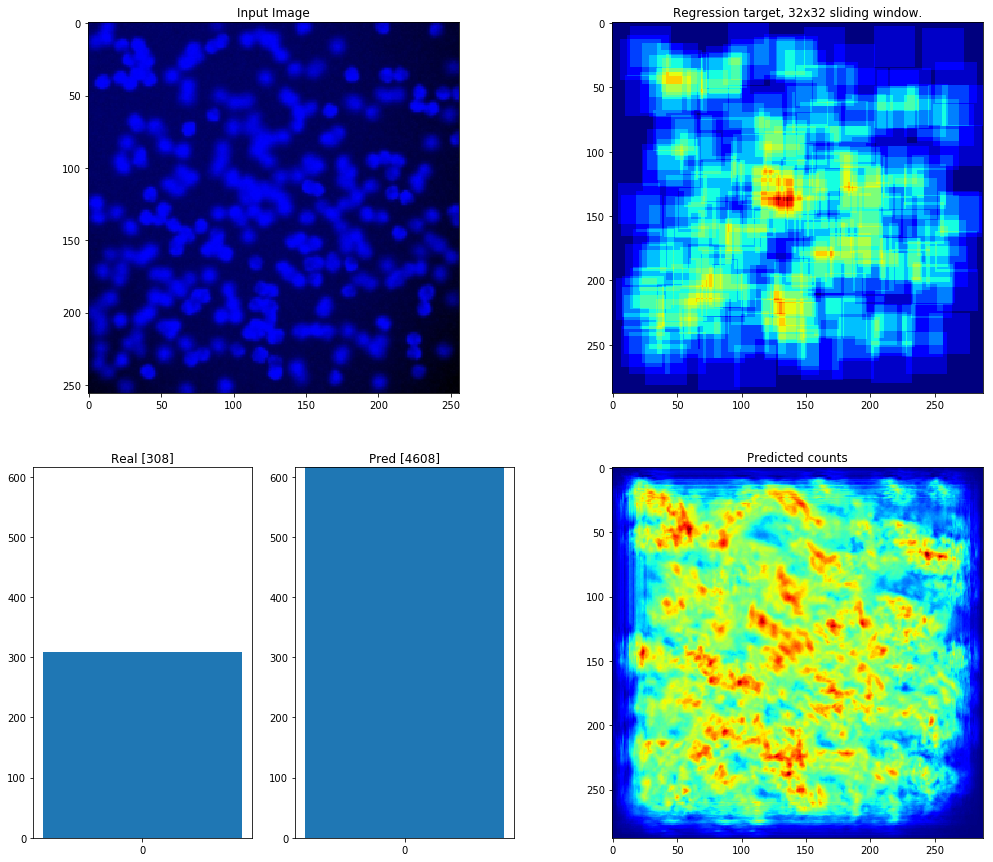

In [18]:
fig = plt.Figure(figsize=(18, 9), dpi=160)
gcf = plt.gcf()
gcf.set_size_inches(18, 15)
fig.set_canvas(gcf.canvas)

ax2 = plt.subplot2grid((2,4), (0, 0), colspan=2)
ax3 = plt.subplot2grid((2,4), (0, 2), colspan=3)
ax4 = plt.subplot2grid((2,4), (1, 2), colspan=3)
ax5 = plt.subplot2grid((2,4), (1, 0), rowspan=1)
ax6 = plt.subplot2grid((2,4), (1, 1), rowspan=1)

ax2.set_title("Input Image")
ax2.imshow(img, interpolation='none',cmap='Greys_r');
ax3.set_title("Regression target, {}x{} sliding window.".format(patch_size, patch_size))
ax3.imshow(np.concatenate((lab),axis=1), interpolation='none');
#ax3.imshow(lab[0], interpolation='none')

ax4.set_title("Predicted counts")
ax4.imshow(np.concatenate((pcount),axis=1), interpolation='none');

ax5.set_title("Real " + str(lab_est))
ax5.set_ylim((0, np.max(lab_est)*2))
ax5.set_xticks(np.arange(0, noutputs, 1.0))
ax5.bar(range(noutputs),lab_est, align='center')
ax6.set_title("Pred " + str(pred_est))
ax6.set_ylim((0, np.max(lab_est)*2))
ax6.set_xticks(np.arange(0, noutputs, 1.0))
ax6.bar(range(noutputs),pred_est, align='center')

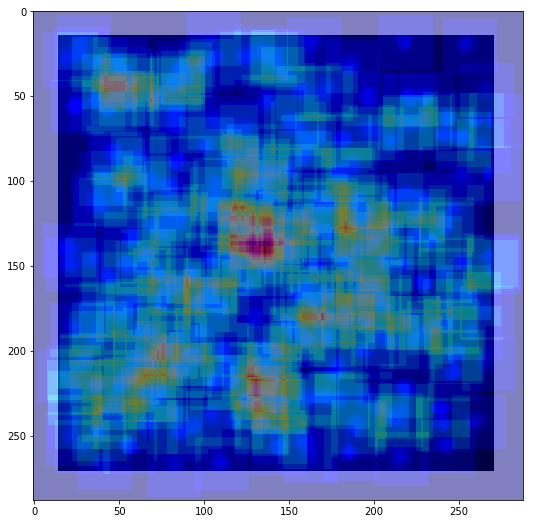

In [19]:
img_pad = np.asarray([np.pad(img[:,:,i],(patch_size-1)/2, "constant", constant_values=255) for i in range(img[0,0].shape[0])])
img_pad = img_pad.transpose((1,2,0))
plt.imshow(img_pad);
plt.imshow(lab[0], alpha=0.5);

In [20]:
for path in imgs: 
    if (not os.path.isfile(path[0])):
        print path, "bad", path[0]
    if (not os.path.isfile(path[1])):
        print path, "bad", path[1]

In [21]:
dataset = []
if (os.path.isfile(datasetfilename)):
    print "reading", datasetfilename
    dataset = pickle.load(open(datasetfilename, "rb" ))
else:
    dataset_x = []
    dataset_y = []
    dataset_c = []
    print len(imgs)
    for path in imgs: 

        imgPath = path[0]
        print imgPath

        im = imread(imgPath)
        img_raw_raw = im
        
        img_raw = scipy.misc.imresize(img_raw_raw, (int(img_raw_raw.shape[0]/args.scale),int(img_raw_raw.shape[1]/args.scale)))
        print img_raw_raw.shape," ->>>>", img_raw.shape

        labelPath = path[1]
        for base_x in range(0,img_raw.shape[0],framesize_h):
            for base_y in range(0,img_raw.shape[1],framesize_w):
                
                if (img_raw.shape[1] - base_y < framesize_w) or (img_raw.shape[0] - base_x < framesize_h):
                    print "!!!! Not adding image because size is" , img_raw.shape[1] - base_y, img_raw.shape[0] - base_x
                    continue
                    
                img, lab, count = getTrainingExampleCells(img_raw, framesize_w, framesize_h, labelPath, base_y, base_x, args.stride, args.scale)
                print "count ", count
                    
                if img.shape[0:2] != (framesize_w,framesize_h):
                    print "!!!! Not adding image because size is" , img.shape[0:2]
                    
                else :   
                    lab_est = [(l.sum()/ef).astype(np.int) for l in lab]
                
                    assert np.allclose(count,lab_est, 0)
                
                    dataset.append((img,lab,count))
                    
                    print "lab_est", lab_est, "img shape", img.shape, "label shape", lab.shape
                    sys.stdout.flush()
                    
        print "dataset size", len(dataset)
                    
    print "writing", datasetfilename
    out = open(datasetfilename, "wb",0)
    pickle.dump(dataset, out)
    out.close()
print "DONE"

reading 1-32-256-sq1-cells-1-dataset.p
DONE


In [22]:
# %matplotlib inline
# plt.rcParams['figure.figsize'] = (18, 9)
# plt.imshow(lab[0])

In [23]:
#np_dataset = np.asarray(dataset)

np.random.shuffle(dataset)

np_dataset_x = np.asarray([d[0] for d in dataset], dtype=theano.config.floatX)
np_dataset_y = np.asarray([d[1] for d in dataset], dtype=theano.config.floatX)
np_dataset_c = np.asarray([d[2] for d in dataset], dtype=theano.config.floatX)


np_dataset_x = np_dataset_x.transpose((0,3,1,2))

print "np_dataset_x", np_dataset_x.shape
print "np_dataset_y", np_dataset_y.shape
print "np_dataset_c", np_dataset_c.shape

np_dataset_x (200, 3, 256, 256)
np_dataset_y (200, 1, 288, 288)
np_dataset_c (200, 1)


In [24]:
length = len(np_dataset_x)

n = args.nsamples

np_dataset_x_train = np_dataset_x[0:n]
np_dataset_y_train = np_dataset_y[0:n]
np_dataset_c_train = np_dataset_c[0:n]
print "np_dataset_x_train", len(np_dataset_x_train)

np_dataset_x_valid = np_dataset_x[n:2*n]
np_dataset_y_valid = np_dataset_y[n:2*n]
np_dataset_c_valid = np_dataset_c[n:2*n]
print "np_dataset_x_valid", len(np_dataset_x_valid)

np_dataset_x_test = np_dataset_x[-100:]
np_dataset_y_test = np_dataset_y[-100:]
np_dataset_c_test = np_dataset_c[-100:]
print "np_dataset_x_test", len(np_dataset_x_test)

np_dataset_x_train 32
np_dataset_x_valid 32
np_dataset_x_test 100


In [25]:
print "number of counts total ", np_dataset_c.sum()
print "number of counts on average ", np_dataset_c.mean(), "+-", np_dataset_c.std()
print "counts min:", np_dataset_c.min(), "max:", np_dataset_c.max()

number of counts total  35192.0
number of counts on average  175.96 +- 61.2449
counts min: 74.0 max: 317.0


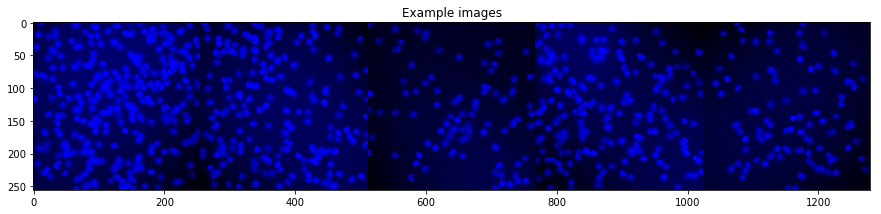

In [26]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Example images")
plt.imshow(np.concatenate(np_dataset_x_train[:5].astype(np.uint8).transpose((0,2,3,1)),axis=1), interpolation='none');

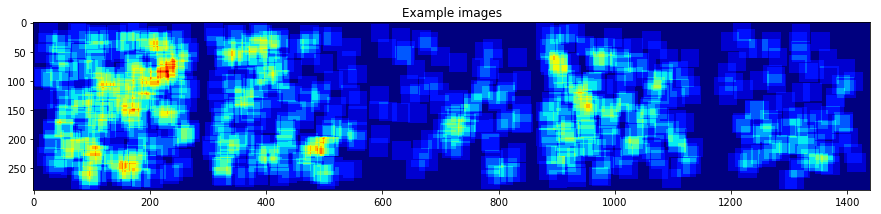

In [27]:
plt.title("Example images")
plt.imshow(np.concatenate(np_dataset_y_train[:5,0],axis=1), interpolation='none');

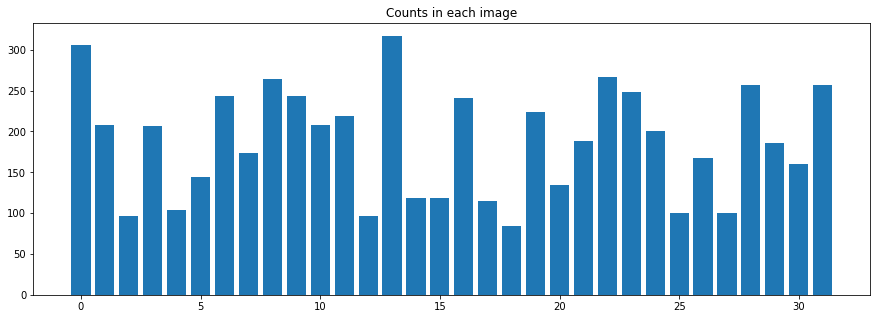

In [28]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Counts in each image")
plt.bar(range(len(np_dataset_c_train)),np_dataset_c_train);

In [29]:
print "Total cells in training", np.sum(np_dataset_c_train[0:], axis=0)
print "Total cells in validation", np.sum(np_dataset_c_valid[0:], axis=0)
print "Total cells in testing", np.sum(np_dataset_c_test[0:], axis=0)

Total cells in training [ 5999.]
Total cells in validation [ 5927.]
Total cells in testing [ 17125.]


In [30]:
#to make video: ffmpeg -i images-cell/image-0-%d-cell.png -vcodec libx264 aout.mp4
def processImages(name, i):
    fig = plt.Figure(figsize=(18, 9), dpi=160)
    gcf = plt.gcf()
    gcf.set_size_inches(18, 15)
    fig.set_canvas(gcf.canvas)
    
    (img, lab, count) = dataset[i]
    
    #print str(i),count
    pcount = classify([img.transpose((2,0,1))], [0])[0]
    
    lab_est = [(l.sum()/(ef)).astype(np.int) for l in lab]
    
    #print lab_est
    
    pred_est = [(l.sum()/(ef)).astype(np.int) for l in pcount]
    
    print str(i),"label est ",lab_est," --> predicted est ",pred_est

    ax2 = plt.subplot2grid((2,6), (0, 0), colspan=2)
    ax3 = plt.subplot2grid((2,6), (0, 2), colspan=5)
    ax4 = plt.subplot2grid((2,6), (1, 2), colspan=5)
    ax5 = plt.subplot2grid((2,6), (1, 0), rowspan=1)
    ax6 = plt.subplot2grid((2,6), (1, 1), rowspan=1)

    ax2.set_title("Input Image")
    ax2.imshow(img, interpolation='none', cmap='Greys_r')
    ax3.set_title("Regression target, {}x{} sliding window.".format(patch_size, patch_size))
    ax3.imshow(np.concatenate((lab),axis=1), interpolation='none')
    ax4.set_title("Predicted counts")
    ax4.imshow(np.concatenate((pcount),axis=1), interpolation='none')

    ax5.set_title("Real " + str(lab_est))
    ax5.set_ylim((0, np.max(lab_est)*2))
    ax5.set_xticks(np.arange(0, noutputs, 1.0))
    ax5.bar(range(noutputs),lab_est, align='center')
    ax6.set_title("Pred " + str(pred_est))
    ax6.set_ylim((0, np.max(lab_est)*2))
    ax6.set_xticks(np.arange(0, noutputs, 1.0))
    ax6.bar(range(noutputs),pred_est, align='center')
    if not os.path.exists('images-cell'): 
        os.mkdir('images-cell')
    fig.savefig('images-cell/image-' + str(i) + "-" + name + '.png', bbox_inches='tight', pad_inches=0)


In [31]:
import pickle, os

directory = "network-temp/"
ext = "countception.p"

if not os.path.exists(directory):
    os.makedirs(directory)
    
def save_network(net,name):
    pkl_params = lasagne.layers.get_all_param_values(net, trainable=True)
    out = open(directory + str(name) + ext, "w", 0) #bufsize=0
    pickle.dump(pkl_params, out)
    out.close()

def load_network(net,name):
    all_param_values = pickle.load(open(directory + str(name) + ext, "r" ))
    lasagne.layers.set_all_param_values(net, all_param_values, trainable=True)

In [32]:
#test accuracy
def test_perf(dataset_x, dataset_y, dataset_c):

    testpixelerrors = []
    testerrors = []
    bs = 1
    for i in range(0,len(dataset_x), bs):

        pcount = classify(dataset_x,range(i,i+bs))
        pixelerr = np.abs(pcount - dataset_y[i:i+bs]).mean(axis=(2,3))
        testpixelerrors.append(pixelerr)
        
        pred_est = (pcount/(ef)).sum(axis=(1,2,3))
        err = np.abs(dataset_c[i:i+bs].flatten()-pred_est)
        
        testerrors.append(err)
    
    return np.abs(testpixelerrors).mean(), np.abs(testerrors).mean()

In [33]:
print "Random performance"
print test_perf(np_dataset_x_train, np_dataset_y_train, np_dataset_c_train)
print test_perf(np_dataset_x_valid, np_dataset_y_valid, np_dataset_c_valid)
print test_perf(np_dataset_x_test, np_dataset_y_test, np_dataset_c_test)

Random performance
(40.911926, 3313.8501)
(41.000946, 3321.0649)
(38.954597, 3155.3105)


In [34]:
target_var = T.tensor4('target')
lr = theano.shared(np.array(args.lr, dtype=theano.config.floatX))

#Mean Absolute Error is computed between each count of the count map
l1_loss = T.abs_(prediction - target_var[input_var_ex])

#Mean Absolute Error is computed for the overall image prediction
prediction_count2 =(prediction/ef).sum(axis=(2,3))
mae_loss = T.abs_(prediction_count2 - (target_var[input_var_ex]/ef).sum(axis=(2,3))) 

loss = l1_loss.mean()

params = lasagne.layers.get_all_params(net, trainable=True)
updates = lasagne.updates.adam(loss, params, learning_rate=lr)

train_fn = theano.function([input_var_ex], [loss,mae_loss], updates=updates,
                         givens={input_var:np_dataset_x_train, target_var:np_dataset_y_train})

print "DONE compiling theano functons"

DONE compiling theano functons


In [35]:
#lr.set_value(0.00005)
best_valid_err = 99999999
best_test_err = 99999999
epoch = 0

In [36]:
batch_size = 2

print "batch_size", batch_size
print "lr", lr.eval()

datasetlength = len(np_dataset_x_train)
print "datasetlength",datasetlength

for epoch in range(epoch, 1000):
    start_time = time.time()

    epoch_err_pix = []
    epoch_err_pred = []
    todo = range(datasetlength)    
    
    for i in range(0,datasetlength, batch_size):
        ex = todo[i:i+batch_size]

        train_start_time = time.time()
        err_pix,err_pred = train_fn(ex)
        train_elapsed_time = time.time() - train_start_time

        epoch_err_pix.append(err_pix)
        epoch_err_pred.append(err_pred)

    valid_pix_err, valid_err = test_perf(np_dataset_x_valid, np_dataset_y_valid, np_dataset_c_valid)

    # a threshold is used to reduce processing when we are far from the goal
    if (valid_err < 10 and valid_err < best_valid_err):
        best_valid_err = valid_err
        best_test_err = test_perf(np_dataset_x_test, np_dataset_y_test,np_dataset_c_test)
        print "OOO best test (err_pix, err_pred)", best_test_err, ",epoch",epoch
        save_network(net,"best_valid_err" + job_id)


    elapsed_time = time.time() - start_time
    err = np.mean(epoch_err_pix)
    acc = np.mean(np.concatenate(epoch_err_pred))
    
    if epoch % 5 == 0:
        print "#" + str(epoch) + "#(err_pix:" + str(np.around(err,3)) + ",err_pred:" +  str(np.around(acc,3)) + "),valid(err_pix:" + str(np.around(valid_pix_err,3)) + ",err_pred:" + str(np.around(valid_err,3)) +"),(time:" + str(np.around(elapsed_time,3)) + "sec)"

    #visualize training
    #processImages(str(epoch) + '-cell',0)

print "#####", "best_test_acc", best_test_err, args

batch_size 2
lr 4.99999987369e-05
datasetlength 32
#0#(err_pix:5.145,err_pred:325.964),valid(err_pix:1.347,err_pred:18.325),(time:12.027sec)
#5#(err_pix:0.873,err_pred:26.005),valid(err_pix:0.818,err_pred:16.218),(time:11.584sec)
#10#(err_pix:0.707,err_pred:17.391),valid(err_pix:0.679,err_pred:17.433),(time:11.58sec)
OOO best test (err_pix, err_pred) (0.57835001, 7.9726171) ,epoch 13
OOO best test (err_pix, err_pred) (0.56074107, 6.4171691) ,epoch 14
OOO best test (err_pix, err_pred) (0.55336022, 5.6579714) ,epoch 15
#15#(err_pix:0.612,err_pred:14.568),valid(err_pix:0.593,err_pred:7.414),(time:22.49sec)
#20#(err_pix:0.552,err_pred:11.796),valid(err_pix:0.566,err_pred:11.554),(time:11.585sec)
#25#(err_pix:0.529,err_pred:12.733),valid(err_pix:0.547,err_pred:12.884),(time:11.59sec)
#30#(err_pix:0.511,err_pred:12.447),valid(err_pix:0.531,err_pred:12.852),(time:11.658sec)
#35#(err_pix:0.49,err_pred:11.014),valid(err_pix:0.502,err_pred:9.667),(time:11.569sec)
#40#(err_pix:0.466,err_pred:9.73

KeyboardInterrupt: 

In [37]:
print "Done"

Done


In [38]:
#load best network
load_network(net,"best_valid_err" + job_id)

In [39]:
def compute_counts(dataset_x):

    bs = 1
    ests = []
    for i in range(0,len(dataset_x), bs):
        pcount = classify(dataset_x,range(i,i+bs))
        pred_est = (pcount/(ef)).sum(axis=(1,2,3))        
        ests.append(pred_est)
    return ests

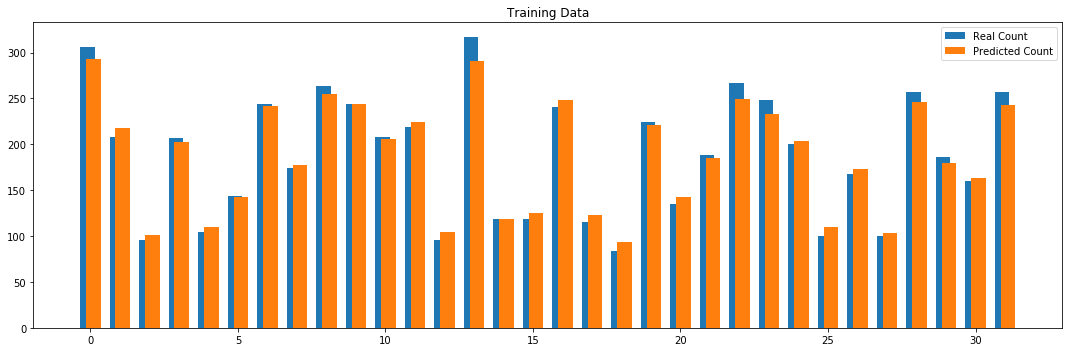

In [40]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Training Data")

pcounts = compute_counts(np_dataset_x_train)
plt.bar(np.arange(len(np_dataset_c_train))-0.1,np_dataset_c_train, width=0.5, label="Real Count");
plt.bar(np.arange(len(np_dataset_c_train))+0.1,pcounts, width=0.5,label="Predicted Count");
plt.tight_layout()
plt.legend()

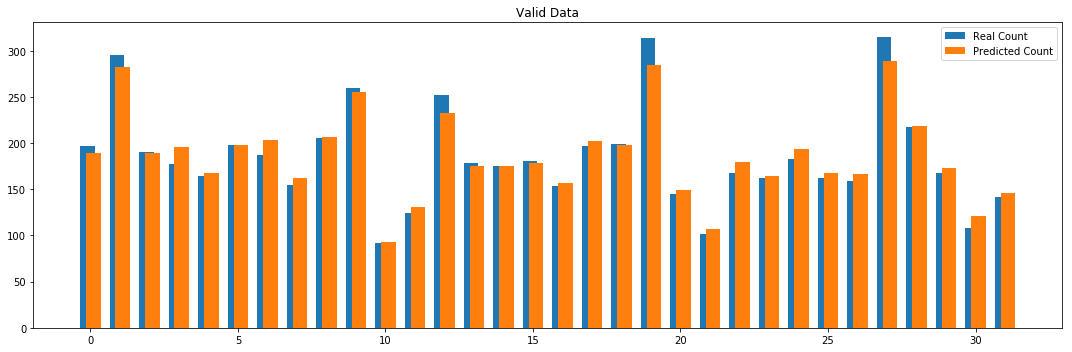

In [41]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Valid Data")

pcounts = compute_counts(np_dataset_x_valid)
plt.bar(np.arange(len(np_dataset_c_valid))-0.1,np_dataset_c_valid, width=0.5, label="Real Count");
plt.bar(np.arange(len(np_dataset_c_valid))+0.1,pcounts, width=0.5,label="Predicted Count");
plt.tight_layout()
plt.legend()

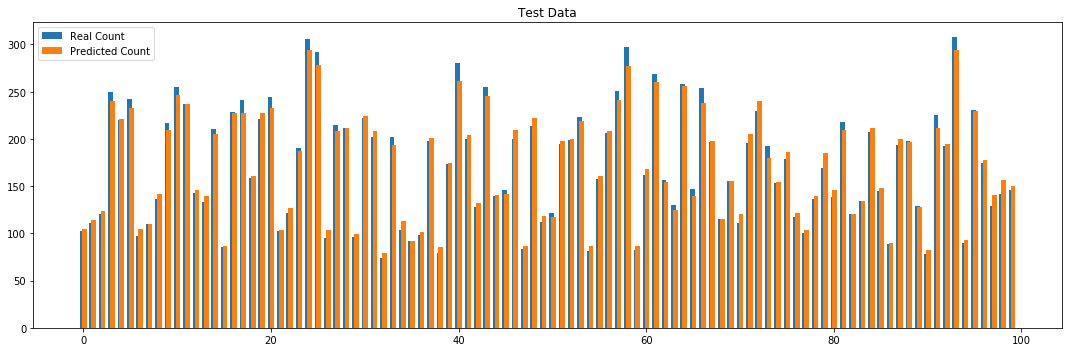

In [42]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.title("Test Data")

pcounts = compute_counts(np_dataset_x_test)
plt.bar(np.arange(len(np_dataset_c_test))-0.1,np_dataset_c_test, width=0.5, label="Real Count");
plt.bar(np.arange(len(np_dataset_c_test))+0.1,pcounts, width=0.5,label="Predicted Count");
plt.tight_layout()
plt.legend()

0 label est  [306]  --> predicted est  [293]


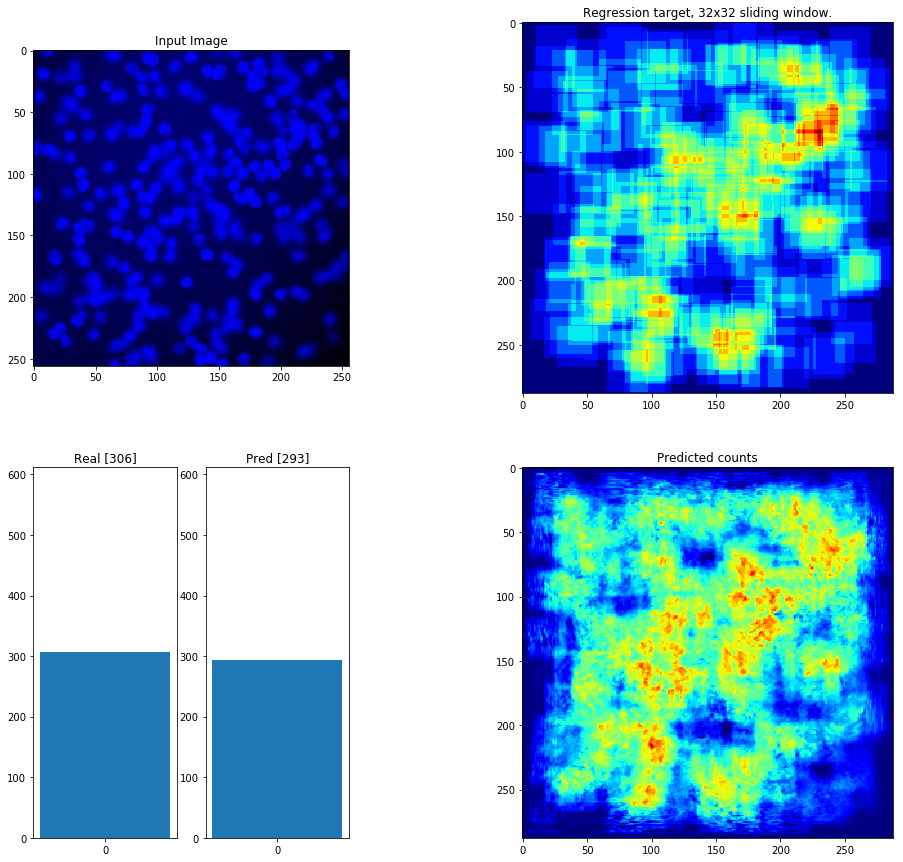

In [43]:
%matplotlib inline
processImages('test',0)

1 label est  [208]  --> predicted est  [218]


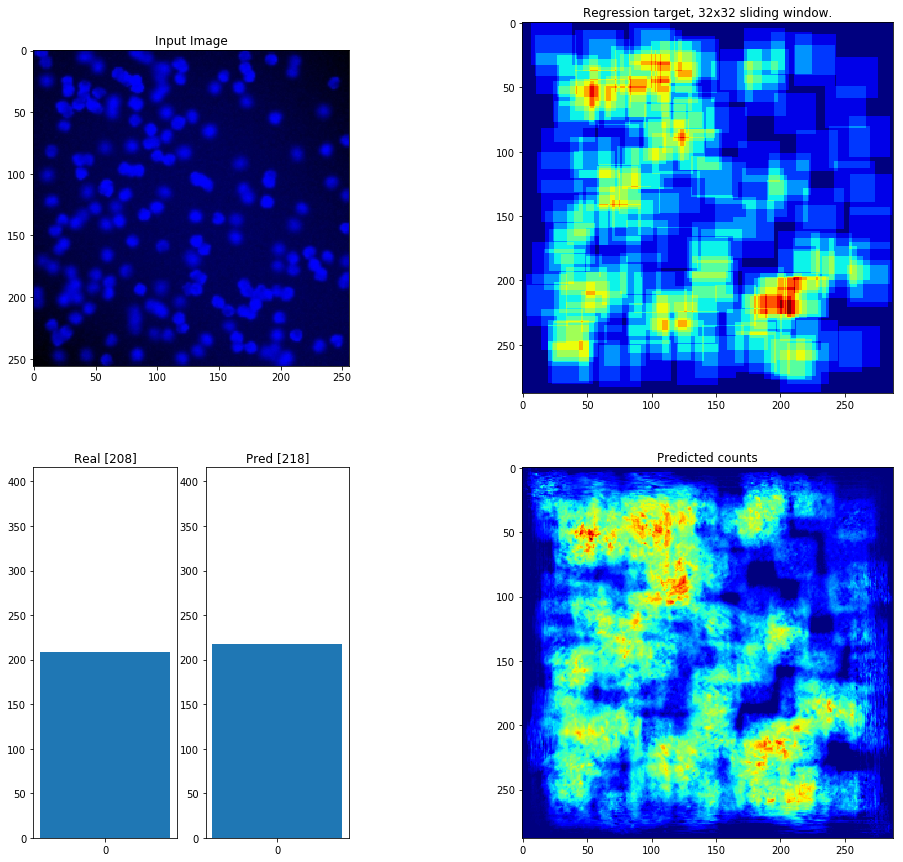

In [44]:
%matplotlib inline
processImages('test',1)

2 label est  [96]  --> predicted est  [101]


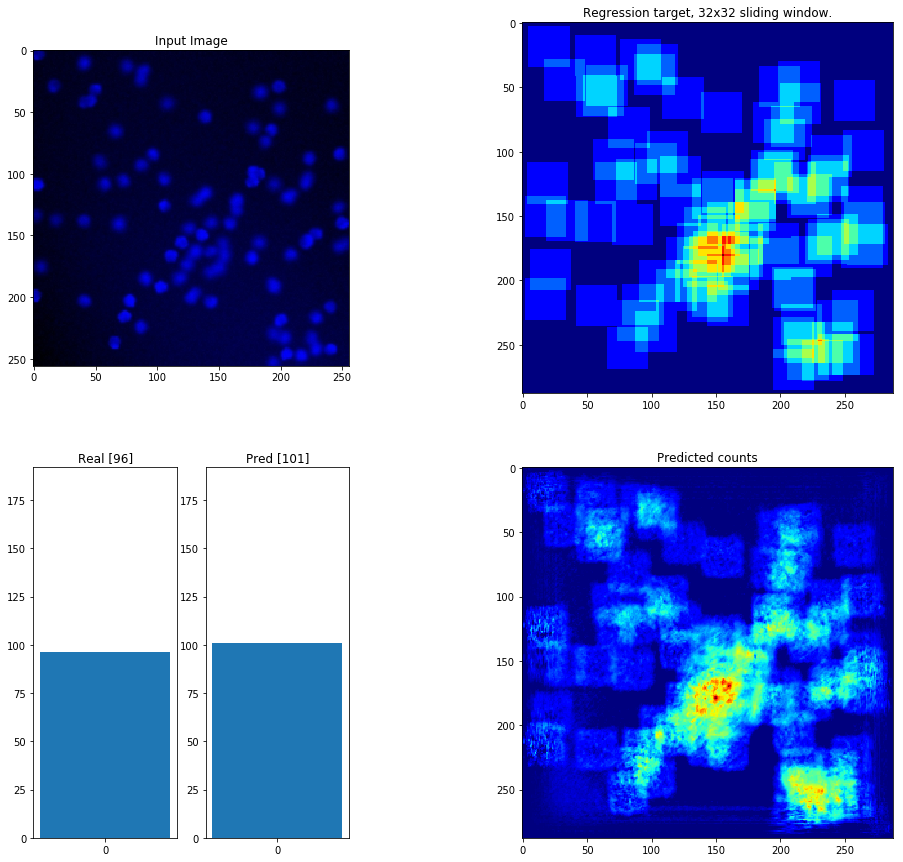

In [45]:
%matplotlib inline
processImages('test',2)

3 label est  [207]  --> predicted est  [202]


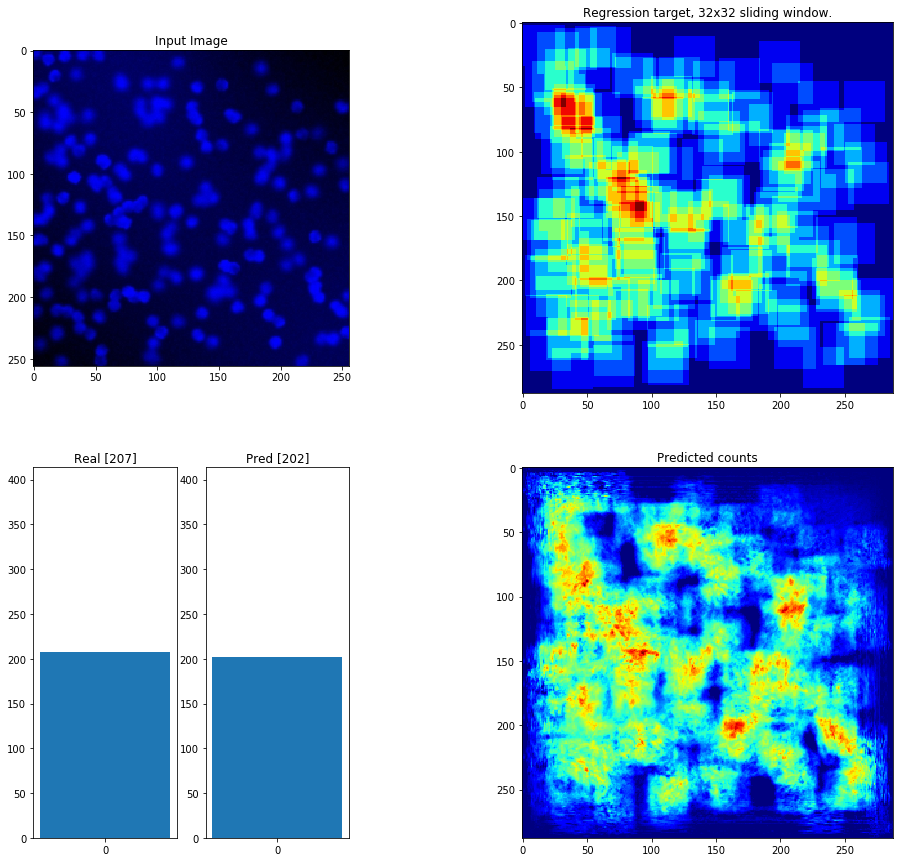

In [46]:
%matplotlib inline
processImages('test',3)

4 label est  [104]  --> predicted est  [109]


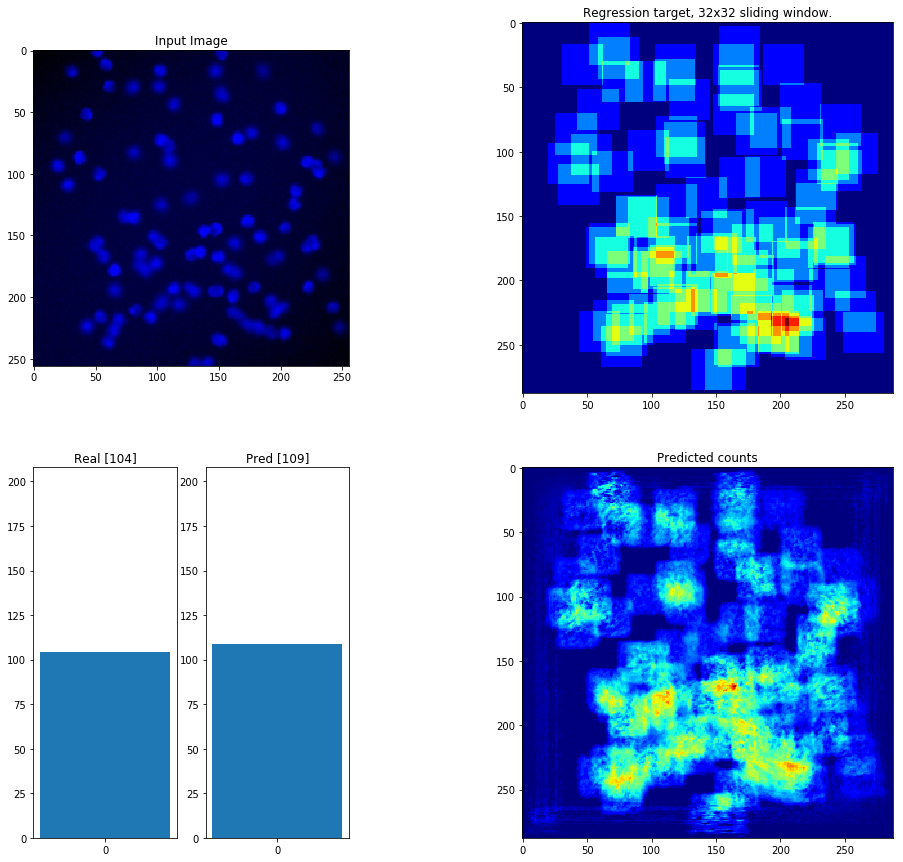

In [47]:
%matplotlib inline
processImages('test',4)

5 label est  [144]  --> predicted est  [142]


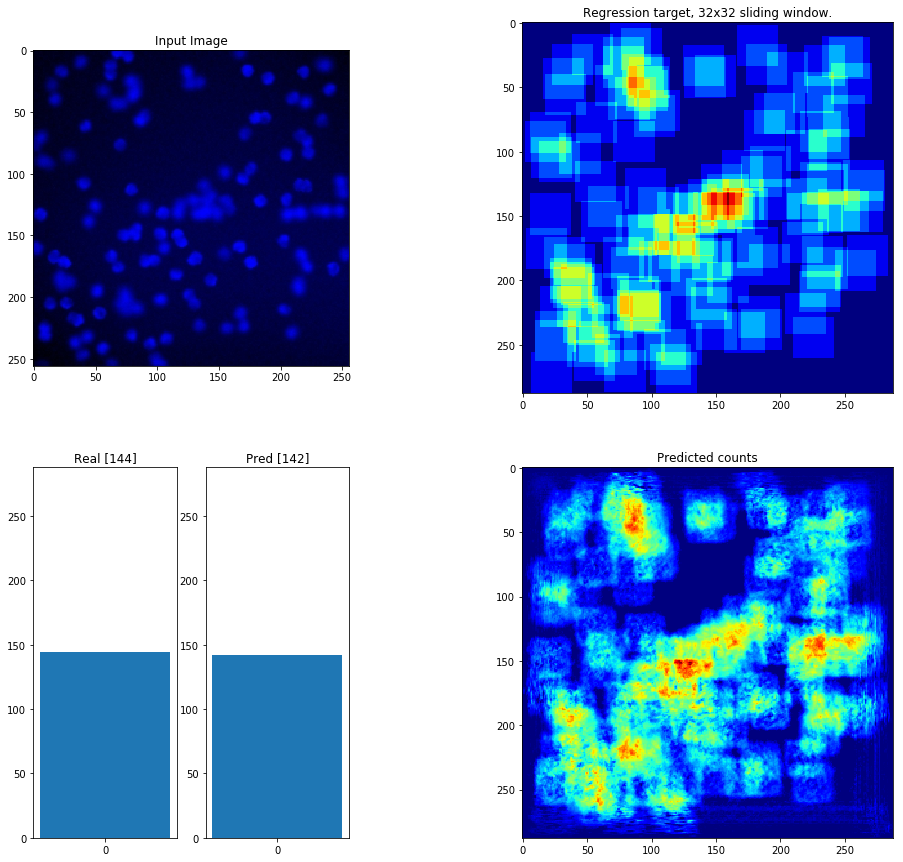

In [48]:
%matplotlib inline
processImages('test',5)

10 label est  [208]  --> predicted est  [205]


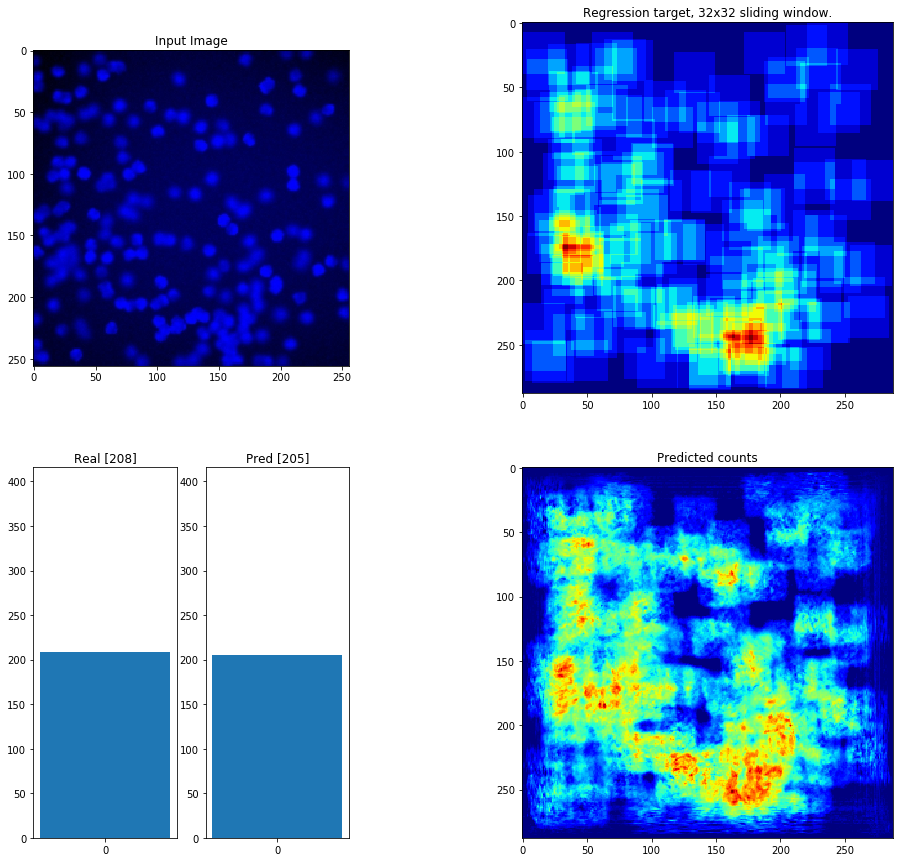

In [49]:
%matplotlib inline
processImages('test',10)